<a href="https://colab.research.google.com/github/EikEUFS/AprendizadoDeMaquina/blob/main/AM_Tarefa_03A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os

import tarfile

import matplotlib.pyplot as plt

import torch as torch
import torch.nn as torchNn
import torch.nn.functional as torchNnF
import torch.utils.data as torchUD
import torch.utils.data.dataloader as torchUDD

import torchvision as torchvision
import torchvision.transforms as torchvisionT
import torchvision.utils as torchvisionU
import torchvision.datasets as torchvisionD
import torchvision.datasets.utils as torchvisionDU

import google.colab as colab

In [3]:
# Download do arquivo para treino, validação e teste
!wget https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz

--2021-05-04 12:25:23--  https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.232.101
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.232.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135107811 (129M) [application/x-tar]
Saving to: ‘cifar10.tgz’

cifar10.tgz         100%[===================>] 128.85M  34.1MB/s    in 4.4s    

2021-05-04 12:25:27 (29.3 MB/s) - ‘cifar10.tgz’ saved [135107811/135107811]



In [4]:
# Extrair o arquivo baixado
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path='./datasets')

In [5]:
data_dir = './datasets/cifar10'

# Listar as classes do arquivo
print(os.listdir(data_dir))
print()
classes= os.listdir(data_dir + '/train')
print(classes)

['test', 'train']

['airplane', 'ship', 'automobile', 'cat', 'dog', 'deer', 'truck', 'bird', 'frog', 'horse']


In [6]:
transform_train = torchvisionT.Compose([
  torchvisionT.Resize(40),
  torchvisionT.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
  torchvisionT.RandomHorizontalFlip(),
  torchvisionT.ToTensor(),
  torchvisionT.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

transform_test = torchvisionT.Compose([
  torchvisionT.ToTensor(),
  torchvisionT.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

In [7]:
train_valid_ds = torchvisionD.ImageFolder(data_dir + '/train', transform=transform_train)

test_ds = torchvisionD.ImageFolder(data_dir + '/test', transform=transform_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  airplane (0)


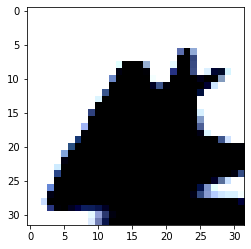

In [8]:
# Teste para ver se mostra imagem
def show_image(img,label):
    print('Label: ', train_valid_ds.classes[label],"("+str(label)+")")
    plt.imshow(img.permute(1,2,0))
    
show_image(train_valid_ds[0][0], train_valid_ds[0][1])

In [9]:
len_dataset_train_valid = len(train_valid_ds)

# Valid = 10% e Train = 90%
valid_size = int(len_dataset_train_valid * 0.1)
train_size = len_dataset_train_valid - valid_size

train_ds, valid_ds = torchUD.random_split(train_valid_ds,[train_size, valid_size])

print(f'TRAIN_SIZE:{len(train_ds)} | VALID_SIZE:{len(valid_ds)}')

TRAIN_SIZE:45000 | VALID_SIZE:5000


In [10]:
# Cria dois Loaders um com batch 4 e outro com batch 128
batch_size_1 = 4
batch_size_2 = 128

train_dl_1 = torchUDD.DataLoader(train_ds, batch_size_1, shuffle=True, num_workers=4, pin_memory=True )
valid_dl_1 = torchUDD.DataLoader(valid_ds, batch_size_1, num_workers=4, pin_memory=True)

train_dl_2 = torchUDD.DataLoader(train_ds, batch_size_2, shuffle=True, num_workers=4, pin_memory=True )
valid_dl_2 = torchUDD.DataLoader(valid_ds, batch_size_2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


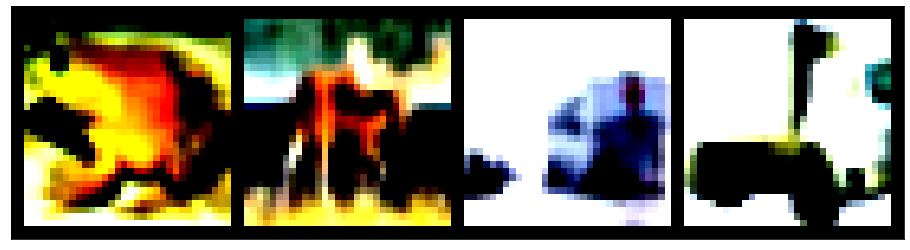

In [11]:
# Visualiza o batch de um loader
def show_images_batch(d1):
  for images, labels in d1:
      fig, ax= plt.subplots(figsize=(16,8))
      ax.set_xticks([])
      ax.set_yticks([])
      ax.imshow(torchvisionU.make_grid(images, nrow=16).permute(1,2,0))
      break
        
show_images_batch(train_dl_1)

In [12]:
# Pega a imagem e aplica o kernel sem padding e striding
def apply_kernel(image, kernel):
  ri, ci = image.shape
  rk, ck = kernel.shape
  ro, co = ri-rk+1, ci-ck+1
  output = torch.zeros([ro, co])
  for i in range(ro): 
      for j in range(co):
          output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel) 
  return output

# Retorna a acurácia
def accuracy(outputs, labels):
  _, preds= torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

class ImageClassificationBase(torchNn.Module):
  # Retorna a taxa de perda
  def training_step(self, batch):
      images, labels = batch
      out = self(images)
      loss = torchNnF.cross_entropy(out, labels)
      return loss
    
  # Retorna a taxa de perda da validação e acurácia - Final
  def validation_step(self, batch):
      images, labels = batch
      out = self(images) 
      loss= torchNnF.cross_entropy(out,labels)
      acc = accuracy(out,labels)
      return {'valid_loss':loss.detach(), 'valid_acc':acc}
  
  # Retorna a taxa de perda da validação e acurácia em cada época e mostra a evolução
  def validation_epoch_end(self, outputs):
      batch_losses = [x['valid_loss'] for x in outputs]
      epoch_loss= torch.stack(batch_losses).mean()
      batch_accs = [x['valid_acc'] for x in outputs]
      epoch_acc = torch.stack(batch_accs).mean()
      return {'valid_loss': epoch_loss.item(), 'valid_acc': epoch_acc.item()}
      
  # Imprime as validações do treino no final da época
  def epoch_end(self,epoch,result):
      print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
          epoch, result['train_loss'], result['valid_loss'], result['valid_acc']))

In [13]:
class Cifar10CnnModel(ImageClassificationBase):
  def __init__(self):
      super().__init__()
      self.network = torchNn.Sequential(
        torchNn.Conv2d(3, 32, kernel_size=3, padding=1),
        torchNn.ReLU(),
        torchNn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        torchNn.ReLU(),
        torchNn.MaxPool2d(2, 2), # output: 64 x 16 x 16

        torchNn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        torchNn.ReLU(),
        torchNn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        torchNn.ReLU(),
        torchNn.MaxPool2d(2, 2), # output: 128 x 8 x 8

        torchNn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        torchNn.ReLU(),
        torchNn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        torchNn.ReLU(),
        torchNn.MaxPool2d(2, 2), # output: 256 x 4 x 4

        torchNn.Flatten(), 
        torchNn.Linear(256*4*4, 1024),
        torchNn.ReLU(),
        torchNn.Linear(1024, 512),
        torchNn.ReLU(),
        torchNn.Linear(512, 10))
      
  def forward(self, xb):
      return self.network(xb)

In [14]:
model_1 = Cifar10CnnModel()
model_2 = Cifar10CnnModel()
model_3 = Cifar10CnnModel()
model_4 = Cifar10CnnModel()

In [ ]:
model_1

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [15]:
# Verifica se tem GPU se não roda em CPU
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

# Modifica os tensors para GPU ou CPU
def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  # Move o dataloader para o GPU ou CPU
  def __init__(self, dl, device):
      self.dl = dl
      self.device = device
      
  # Move o batch para o GPU ou CPU
  def __iter__(self):
      for b in self.dl: 
          yield to_device(b, self.device)

  # Retorna o tamanho do batch
  def __len__(self):
      return len(self.dl)

In [16]:
# Retorna se é GPU ou CPU
device = get_default_device()
device

device(type='cuda')

In [17]:
train_dl_1 = DeviceDataLoader(train_dl_1, device)
valid_dl_1 = DeviceDataLoader(valid_dl_1, device)

train_dl_2 = DeviceDataLoader(train_dl_2, device)
valid_dl_2 = DeviceDataLoader(valid_dl_2, device)

to_device(model_1, device)
to_device(model_2, device)
to_device(model_3, device)
to_device(model_4, device)

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [18]:
# Retorna a evolução do modelo
@torch.no_grad() 
def evaluate(model, val_loader):
    model.eval() # Modelo para avaliação
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Treina e Valida o modelo
def fit(model, train_loader, val_loader, epochs, lr, opt_func= torch.optim.SGD):
    history=[]
    optimizer= opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        # ---------- TREINO ----------
        model.train()
        train_losses=[]
        for batch in train_loader:
            loss= model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # ---------- VALIDAÇÃO ----------
        result= evaluate(model,val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [19]:
def plot_accuracies(history):
  accuracies=[x['valid_acc'] for x in history]
  plt.plot(accuracies,'-x')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Accuracy vs No of epochs')
    
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['valid_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs');

In [20]:
num_epochs_1 = 5
num_epochs_2 = 100

optimizer_function = torch.optim.Adam
lr = 0.001

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.7697, val_loss: 1.5771, val_acc: 0.4164
Epoch [1], train_loss: 1.4814, val_loss: 1.3428, val_acc: 0.5090
Epoch [2], train_loss: 1.3697, val_loss: 1.3338, val_acc: 0.5222
Epoch [3], train_loss: 1.3159, val_loss: 1.2469, val_acc: 0.5598
Epoch [4], train_loss: 1.2566, val_loss: 1.3058, val_acc: 0.5306


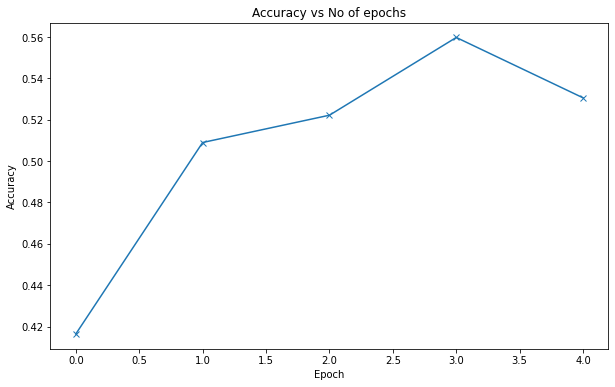

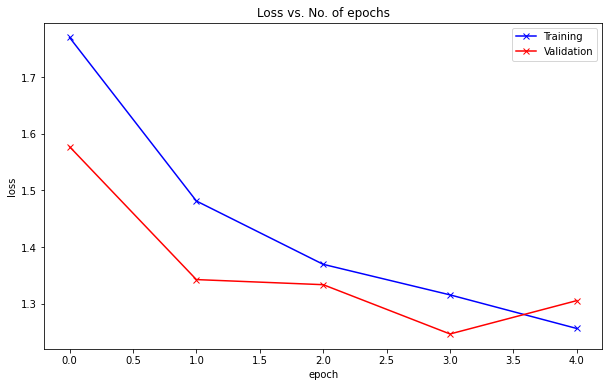

In [ ]:
history_1 = fit(model_1, train_dl_1, valid_dl_1, num_epochs_1, lr, optimizer_function)

plt.figure(figsize=(10,6))
plot_accuracies(history_1)

plt.figure(figsize=(10,6))
plot_losses(history_1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.7200, val_loss: 1.3688, val_acc: 0.4775
Epoch [1], train_loss: 1.2458, val_loss: 1.0642, val_acc: 0.6170
Epoch [2], train_loss: 1.0055, val_loss: 0.8754, val_acc: 0.6881
Epoch [3], train_loss: 0.8391, val_loss: 0.8066, val_acc: 0.7160
Epoch [4], train_loss: 0.7365, val_loss: 0.7274, val_acc: 0.7484


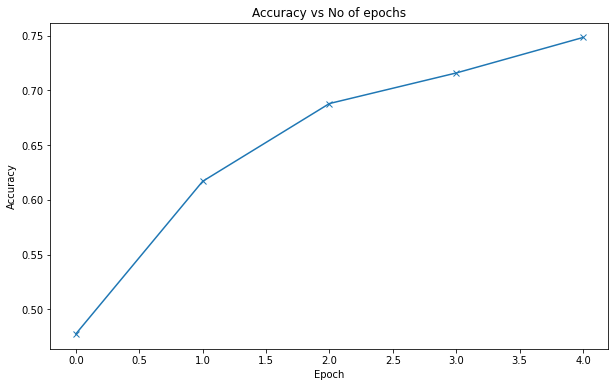

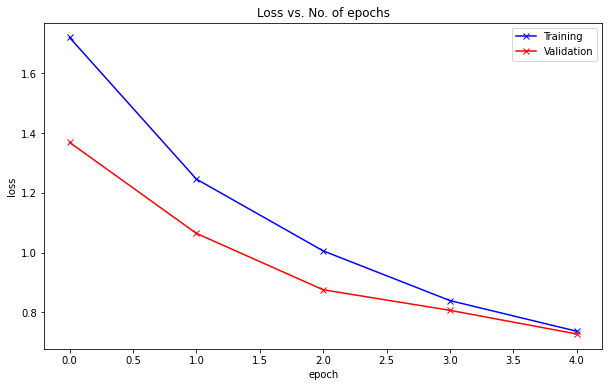

In [ ]:
history_2 = fit(model_2, train_dl_2, valid_dl_2, num_epochs_1, lr, optimizer_function)

plt.figure(figsize=(10,6))
plot_accuracies(history_2)

plt.figure(figsize=(10,6))
plot_losses(history_2)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.6990, val_loss: 1.5527, val_acc: 0.4436
Epoch [1], train_loss: 1.3813, val_loss: 1.3219, val_acc: 0.5304
Epoch [2], train_loss: 1.2736, val_loss: 1.2140, val_acc: 0.5734
Epoch [3], train_loss: 1.2052, val_loss: 1.1104, val_acc: 0.6080
Epoch [4], train_loss: 1.1642, val_loss: 1.1057, val_acc: 0.6070
Epoch [5], train_loss: 1.1369, val_loss: 1.1199, val_acc: 0.6120
Epoch [6], train_loss: 1.1187, val_loss: 1.0791, val_acc: 0.6182
Epoch [7], train_loss: 1.0916, val_loss: 1.0632, val_acc: 0.6362
Epoch [8], train_loss: 1.0703, val_loss: 1.0635, val_acc: 0.6418
Epoch [9], train_loss: 1.0545, val_loss: 1.0699, val_acc: 0.6178
Epoch [10], train_loss: 1.0529, val_loss: 1.0129, val_acc: 0.6594
Epoch [11], train_loss: 1.0450, val_loss: 1.0237, val_acc: 0.6588
Epoch [12], train_loss: 1.0853, val_loss: 1.0371, val_acc: 0.6432
Epoch [13], train_loss: 1.0902, val_loss: 1.0366, val_acc: 0.6504
Epoch [14], train_loss: 1.2194, val_loss: 1.1990, val_acc: 0.5868
Epoch [15], train_lo

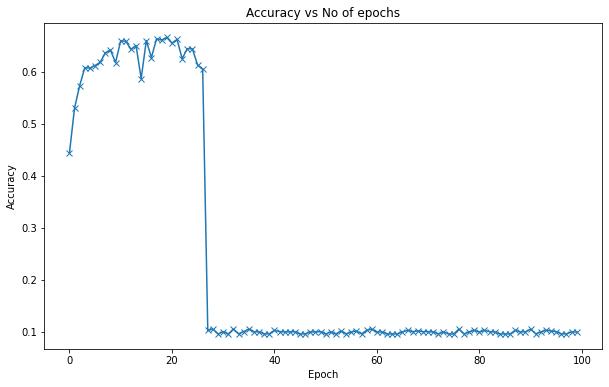

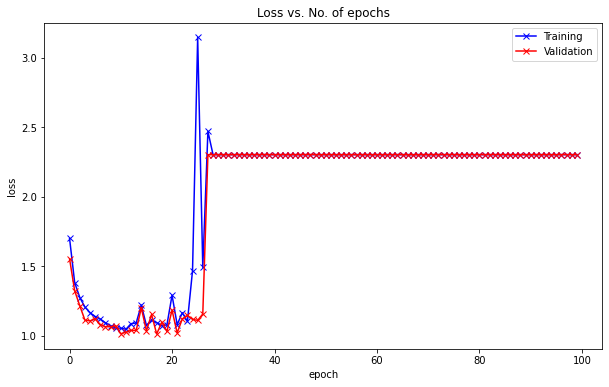

In [22]:
history_3 = fit(model_3, train_dl_1, valid_dl_1, num_epochs_2, lr, optimizer_function)

plt.figure(figsize=(10,6))
plot_accuracies(history_3)

plt.figure(figsize=(10,6))
plot_losses(history_3)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.6631, val_loss: 1.3516, val_acc: 0.5061
Epoch [1], train_loss: 1.1891, val_loss: 1.0457, val_acc: 0.6420
Epoch [2], train_loss: 0.9206, val_loss: 0.8394, val_acc: 0.7094
Epoch [3], train_loss: 0.7637, val_loss: 0.7586, val_acc: 0.7381
Epoch [4], train_loss: 0.6843, val_loss: 0.7231, val_acc: 0.7475
Epoch [5], train_loss: 0.6082, val_loss: 0.6287, val_acc: 0.7857
Epoch [6], train_loss: 0.5566, val_loss: 0.6011, val_acc: 0.7939
Epoch [7], train_loss: 0.5166, val_loss: 0.6155, val_acc: 0.7871
Epoch [8], train_loss: 0.4738, val_loss: 0.5723, val_acc: 0.8057
Epoch [9], train_loss: 0.4423, val_loss: 0.5496, val_acc: 0.8133
Epoch [10], train_loss: 0.4080, val_loss: 0.5516, val_acc: 0.8145
Epoch [11], train_loss: 0.3888, val_loss: 0.5887, val_acc: 0.8037
Epoch [12], train_loss: 0.3643, val_loss: 0.5534, val_acc: 0.8158
Epoch [13], train_loss: 0.3428, val_loss: 0.5511, val_acc: 0.8219
Epoch [14], train_loss: 0.3250, val_loss: 0.5447, val_acc: 0.8244
Epoch [15], train_lo

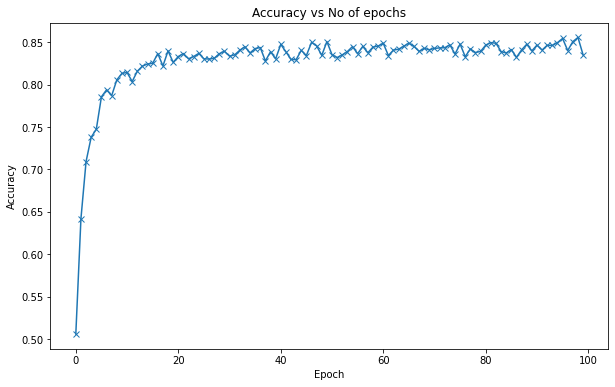

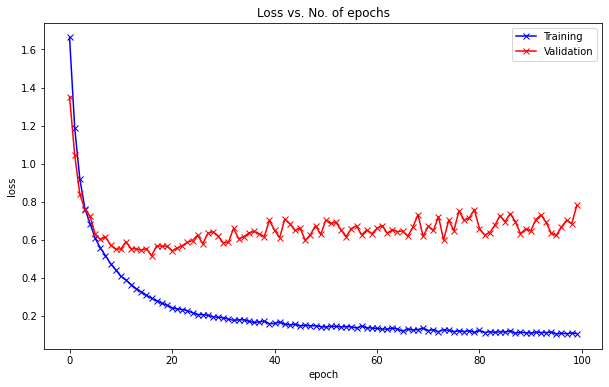

In [21]:
history_4 = fit(model_4, train_dl_2, valid_dl_2, num_epochs_2, lr, optimizer_function)

plt.figure(figsize=(10,6))
plot_accuracies(history_4)

plt.figure(figsize=(10,6))
plot_losses(history_4)